<a href="https://colab.research.google.com/github/ambervill/deep-learning-with-python-notebooks/blob/master/Dataset_preparing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предобработка обучающей выборки

In [1]:
!pip install pymupdf

In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
from PIL import Image
import tensorflow as tf
import cv2
from google.colab import files

In [3]:
# uploaded = files.upload()
# file_name = list(uploaded.keys())[0]
# print(f"File uploaded: {file_name}")
file_name = '/content/drive/MyDrive/Нейросети/report-125084_kriterii-testa-risunok-cheloveka__202408101554.xlsx'
df = pd.read_excel(file_name)

In [4]:
df = df[3:len(df.index) - 12]

In [5]:
df.drop(columns=['ID ответа',	'Дата ответа',	'Затраченное время',	'Источник ответа',	'Источник ответа.1',	'Респондент',	'IP-hash',	'UA-hash',	'Логин'], inplace=True)

In [6]:
pd.set_option('display.max_columns', 500)
df

,Страница 1,Страница 2,Страница 3,Страница 5,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Страница 6,Страница 7,Страница 8,Страница 9,Страница 10,Страница 11,Страница 12,Страница 13,Unnamed: 36,Unnamed: 37,Unnamed: 38,Страница 14,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Страница 15,Страница 16,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Страница 17,Страница 18,Страница 19,Страница 20,Unnamed: 62,Unnamed: 63,Unnamed: 64,Страница 21,Страница 23,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Страница 24,Unnamed: 102,Unnamed: 103,Страница 25,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Страница 26,Страница 27,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Страница 28,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Страница 29,Страница 30,Страница 31,Страница 32,Страница 33,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Страница 34,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Страница 35,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Страница 36,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Страница 37,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Страница 38,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Страница 39,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Страница 40,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Страница 41,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Страница 42,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Страница 43,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Страница 44,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Страница 45,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Страница 46,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Страница 47,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Страница 48,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Страница 49,Страница 50,Страница 51,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Страница 52,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Страница 53
3,143ФРМ8лм1кл,8,мужской,NaN,NaN,NaN,NaN,Смещение вниз/5,NaN,NaN,NaN,NaN,NaN,сильно/2,NaN,NaN,NaN,NaN,NaN,"Стандарт/3,",Стандарт (фас) /1,Стоит/1,нет/2,Дифференцированная схема/2,нет/2,NaN,NaN,NaN,NaN,Сильно варьирует/4,NaN,NaN,Эскизные/3,"""Кусочные""/4",NaN,NaN,NaN,NaN,Высокая/3,Высокая/3,NaN,NaN,Низкая/2,нет/2,NaN,NaN,NaN,NaN,NaN,"Средняя (стандарт)/3,",Слабо выражены/2,вполне устойчив/1,NaN,NaN,Нарушение пропорций/3,NaN,нет/2,Без особенностей/1,NaN,NaN,NaN,NaN,NaN,Глаза (один или оба)/1,NaN,Рот/3,NaN,Лоб/5,Волосы (шапка)/6,NaN,NaN,"Овал, реалистичная форма/4",Средний (стандарт)/2,Без особенностей/1,NaN,NaN,NaN,NaN,NaN,NaN,Отсутствуют/1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Средний (стандарт)/3,NaN,NaN,NaN,Замкнутый контур/4,Отсутствуют/1,Отсутствует/1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Средний (стандар

## Function to convert PDF page to image

In [7]:
# Function to convert PDF page to image
def pdf_page_to_image(pdf_path, page_number):
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    # Select the page
    page = pdf_document.load_page(page_number)

    # Get the pixmap (image) of the page
    pix = page.get_pixmap()

    # Convert the pixmap to a PIL image
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples).resize((300,300))

    return img

In [8]:
# Function to convert PIL image to NumPy array
def image_to_numpy_array(img):
    return np.array(img)

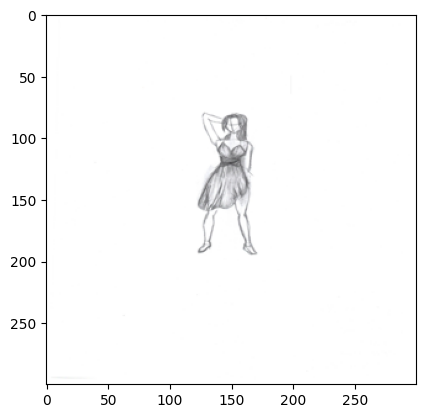

In [9]:
# Example usage
pdf_path = '/content/drive/MyDrive/Нейросети/2024 Нейросети/Нейросети (сортировка по классам)/7-8 класс (13-15 лет)/494_13лж8кл.pdf'
page_number = 1  # 0-indexed page in the document

# Convert PDF page to image
img = pdf_page_to_image(pdf_path, page_number)

# Convert image to NumPy array
img_array = image_to_numpy_array(img)

# Optional: Display the image (if running in an environment that supports it)
plt.imshow(img_array)

## Функции для конвертации выборки в формат TFRecord

In [10]:
# Helper function to serialize an example
def serialize_example(image, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
        # 'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(label, encoding='utf-8')])),
        # 'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label['pressure_normal'], label['pressure_low'], label['pressure_high'], label['pressure_variable']])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label['shift_normal'], label['shift_right'], label['shift_left'], label['shift_up'], label['shift_down']])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [11]:
# Write TFRecord file
def write_tfrecord(file_path, images, labels):
    with tf.io.TFRecordWriter(file_path) as writer:
        for image, label in zip(images, labels):
            example = serialize_example(image, label)
            writer.write(example)

## Конвертация всех размеченных файлов из директории `Команды для нейросети` в TFRecord

In [12]:
from google.colab import auth
import gspread
from google.auth import default
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open("Dataset check")

In [13]:
folder_path = '/content/drive/MyDrive/Нейросети/Команды для нейросетей/'
file_list = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_list.append(os.path.join(root, file))

In [14]:
# Всего 4249 файлов
len(file_list)

4250

In [15]:
# flipped_filenames = []
# for file in open('/content/drive/MyDrive/Нейросети/flipped.txt').readlines():
#   flipped_filenames.append(file.strip())

# rotated90_filenames = []
# for file in open('/content/drive/MyDrive/Нейросети/rotated90.txt').readlines():
#   rotated90_filenames.append(file.strip())

# rotated180_filenames = []
# for file in open('/content/drive/MyDrive/Нейросети/rotated180.txt').readlines():
#   rotated180_filenames.append(file.strip())

# rotated270_filenames = []
# for file in open('/content/drive/MyDrive/Нейросети/rotated270.txt').readlines():
#   rotated270_filenames.append(file.strip())

In [16]:
sheet = spreadsheet.worksheet("Рисунок на стр. 2")
flipped_filenames = sheet.col_values(1)

sheet = spreadsheet.worksheet("Влево 90")
rotated90_filenames = sheet.col_values(1)

sheet = spreadsheet.worksheet("Перевернутые")
rotated180_filenames = sheet.col_values(1)

sheet = spreadsheet.worksheet("Вправо 90")
rotated270_filenames = sheet.col_values(1)

sheet = spreadsheet.worksheet("Непроверенные")
unchecked_filenames = sheet.col_values(1)

In [17]:
flipped_file_list = []
for file in file_list:
  filename = file[file.rfind('/') + 1 : file.find('.pdf')]
  if  filename in flipped_filenames:
    flipped_file_list.append(file)

file_list = [file for file in file_list if file not in flipped_file_list]

In [18]:
len(flipped_file_list)

519

In [19]:
len(file_list)

3731

In [20]:
# # File path where the list will be written
# file_path = "all_files.txt"

# # Open the file in write mode
# with open(file_path, "w") as file:

#     # Write each element of the list to a new line
#     for item in file_list:
#       filename = item[item.rfind('/') + 1 : item.find('.pdf')]
#       file.write(filename + "\n")

In [21]:
def file_list_to_image_arrays(list_of_files, page_number):
  global images, labels
  i = 0
  for file in list_of_files[len(labels):]:
    filename = file[file.rfind('/') + 1 : file.find('.pdf')]
    line = df.loc[ df['Страница 1'] == filename ]
    if len(line) > 0:
      print(f'Processing file {file}')
      i += 1
      # Convert PDF page to image
      img = pdf_page_to_image(file, page_number)
      if filename in rotated90_filenames:
        image = np.rot90(np.array([img]), axes=(1, 2), k=-1)
      elif filename in rotated180_filenames:
        image = np.rot90(np.array([img]), axes=(1, 2), k=2)
      elif filename in rotated270_filenames:
        image = np.rot90(np.array([img]), axes=(1, 2), k=1)
      else:
        image = np.array([img])
      images = np.append(images, image, axis=0)
      label = {}
      # label['pressure_normal'] = 1 if line['Страница 13'].iat[0] == 'Без особенностей/1' else 0
      # label['pressure_low'] = 1 if line['Unnamed: 36'].iat[0] == 'Слабый/2'  else 0
      # label['pressure_high'] = 1 if line['Unnamed: 37'].iat[0] == 'Сильный/3' else 0
      # label['pressure_variable'] = 1 if line['Unnamed: 38'].iat[0] == 'Сильно варьирует/4' else 0
      label['shift_normal'] = 1 if line['Страница 5'].iat[0] == 'Без особенностей/1 ' else 0
      label['shift_right'] = 1 if line['Unnamed: 13'].iat[0] == 'Смещение вправо/2' else 0
      label['shift_left'] = 1 if line['Unnamed: 14'].iat[0] == 'Смещение влево/3' else 0
      label['shift_up'] = 1 if line['Unnamed: 15'].iat[0] == 'Смещение вверх/4' else 0
      label['shift_down'] = 1 if line['Unnamed: 16'].iat[0] == 'Смещение вниз/5' else 0
      # print(f'filename: {filename}, label: {label}, iat: {line["Страница 5"].iat[0]}')
      labels.append(label)
      if i % 100 == 0:
        print(f'Processed #{i}')
        break
    # if i > 100:
    #   break

In [22]:
# images = np.empty((0, 300, 300, 3))
# labels = np.array([])
# labels = []
images = np.load('/content/drive/MyDrive/Нейросети/images_train.npy')
labels = list(np.load('/content/drive/MyDrive/Нейросети/labels_train.npy', allow_pickle=True))

In [ ]:
file_list_to_image_arrays(file_list, page_number=0)

In [24]:
np.save('/content/drive/MyDrive/Нейросети/images_train.npy', images)

In [25]:
np.save('/content/drive/MyDrive/Нейросети/labels_train.npy', labels)

In [66]:
write_tfrecord('/content/drive/MyDrive/Нейросети/train.tfrecord', images, labels)

In [ ]:
images = np.empty((0, 300, 300, 3))
# labels = np.array([])
labels = []

In [ ]:
file_list_to_image_arrays(flipped_file_list, page_number=1)

Processed #100
Processed #200


In [ ]:
write_tfrecord('/content/drive/MyDrive/Нейросети/test.tfrecord', images, labels)

In [ ]:
images.shape

(235, 300, 300, 3)

In [ ]:
images

NameError: name 'images' is not defined

## Визуализация 1-й страницы каждого файла

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

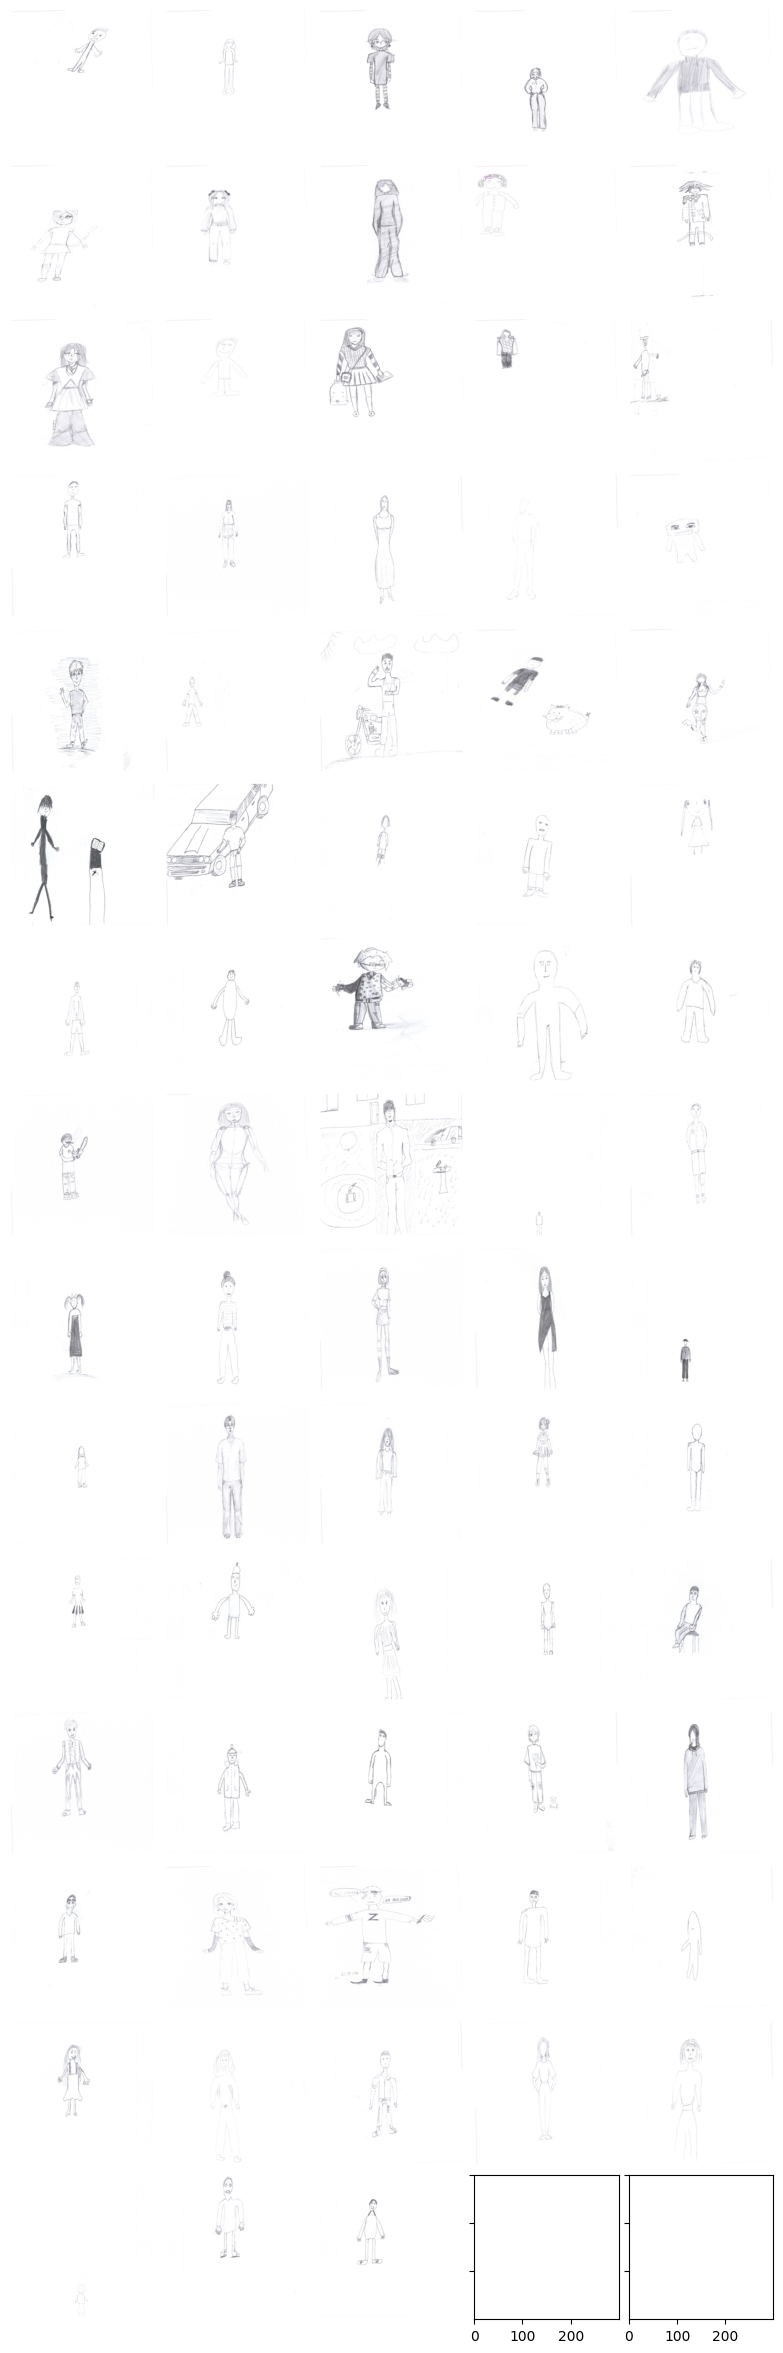

In [ ]:
fig = plt.figure(figsize=(10., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(15, 5),  # creates grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )
for ax, img in zip(grid, images):

  # Convert image to NumPy array
  ax.imshow(img / 255.0)
  ax.set_axis_off()
  # ax.annotate(filename, (0,0))

plt.show()

## Поиск непроверенных файлов и их скачивание

In [ ]:
# fig = plt.figure(figsize=(80., 80.))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(20, 5),  # creates grid of Axes
#                  axes_pad=0.1,  # pad between Axes in inch.
#                  )


# for ax, file in zip(grid, sorted(file_list[290:300])):

#   filename = file[file.rfind('/') + 1 : file.find('.pdf')]

#   print(file)
#   page_number = 0  # 0-indexed page in the document
#   # Convert PDF page to image
#   img = pdf_page_to_image(file, page_number)
#   # Convert image to NumPy array
#   ax.imshow(np.array(img))
#   ax.set_axis_off()
#   ax.annotate(filename, (0,0))

# # plt.show()
# plt.savefig('destination_path.eps', format='eps')

In [ ]:
# with open('file_list.txt', 'w') as filehandle:
#     for file in file_list:
        # filename = file[file.rfind('/') + 1 : file.find('.pdf')]
#       filehandle.write(filename)
#       filehandle.write('\n')

In [35]:
# directory_path = '/content/drive/MyDrive/Нейросети/all/'
# try:
#   files = os.listdir(directory_path)
#   for file in files:
#     file_path = os.path.join(directory_path, file)
#     if os.path.isfile(file_path):
#       os.remove(file_path)
#   print("All files deleted successfully.")
# except OSError:
#   print("Error occurred while deleting files.")

All files deleted successfully.


In [ ]:
# for file in sorted(file_list[:400]):
#   try:
#     filename = file[file.rfind('/') + 1 : file.find('.pdf')]
#     page_number = 0  # 0-indexed page in the document
#     # Convert PDF page to image
#     img = pdf_page_to_image(file, page_number)
#     image_path = '/content/drive/MyDrive/Нейросети/all/' + filename + '.png'
#     plt.imsave(image_path, np.array(img))
#   except:
#     pass

In [ ]:
for file in file_list:
  try:
    filename = file[file.rfind('/') + 1 : file.find('.pdf')]
    if filename in flipped_files:
      # print(file)
      page_number = 1  # 0-indexed page in the document
      # Convert PDF page to image
      img = pdf_page_to_image(file, page_number)
      image_path = '/content/drive/MyDrive/Нейросети/all/' + filename + '.png'
      plt.imsave(image_path, np.array(img))
  except:
    pass

## Поиск файлов с ошибочными идентификаторами

In [ ]:
sheet = spreadsheet.worksheet("Проверенные файлы")

# Get all values in the first column
first_column_values = sheet.col_values(1)

# Print the first column values
print(first_column_values)

['Имя файла', '552ЛА6лждс', '908НН12лж5кл', '539ГС9лж3кл', '412_14лж7кл', '813ЭЛЕ13лм6кл', '481_14лм7кл', '715ЗАВ5лждс', '869ШМВ6лмдс', '408ЭЛЕ12лм5кл', '962_14лмсршк', '117ВМ5лмдс', '621ТА5лмдс', '870ШОЛ6лждс', '656_14лж8кл', '789_14лм8кл', '902ЭЛЕ5лмдс', '8ЛСА10лж3кл', '443ЭЛЕ7лж1кл', '774_14лм8кл', '606СА7лждс', '969ЛГ8лм1кл', '3_12лм7кл', '809ЭЛЕ13лм5кл', '1066ЭЛЕ6лмдс', '965ЭЛЕ6л7ммдс', '866НН12лж5кл', '531_14лж8кл', '110НМ5лмдс', '137МА12лжош', '50_13лж7кл', '766НН10лммлшк', '416ЭЛЕ9лм3кл', '557ДЧД12лм5кл', '593ИА12лж6кл', '295КС5лмдс', '650_14лж8кл', '945_14лжсршк', '98ЛУВ9лж3кл', '1042БТ9лм3кл', '61_13лж7кл', '863НН12лж5кл', '506ДВ10лж4кл', '321_13лм7кл', '29ПМИ11лм4кл', '207РД11лж5кл', '912ИД7лм1кл', '554ГВА12лж5кл', '864НН11лм5кл', '212_13лм7кл', '717КС9лж3кл', '937_13лмсршк', '459_14лм7кл', '52МА12лж6кл', '650НН10лж3кл', '530ЯД8лммлшк', '258ЭЛЕ12лж6кл', '97_13лж7кл', '910_13лжсршк', '623АД12лм6кл', '805ПСА6лмдс', '655АВ8лж3кл', '316ГЮ5,11лждс', '74_13лж7кл', '49_13лж7кл', '2

In [ ]:
filtered_df = df[~df['Страница 1'].isin(first_column_values)]

In [ ]:
len(filtered_df)

44

In [ ]:
unknown_files = filtered_df['Страница 1'].values

In [ ]:
for file in unknown_files:
  print(file)

150ОНЕ6лждс
500ЭЛЕ12лж
506_НН12лж5кл
498ЭЛЕ12лм
495_12лж8кл
487ЭЛЕ11лм5кл
485_13лм7кл
473_14л7кл
417_14лм7кл
464ЭЛЕ12ль5кл
467_14лм7кл
453ЭЛЭ11лж5кл
614ЕИ13лж6кл
789ммп12лж5кл
798гпв12лм5кл
799эле13лж6кл
801эле14лж6кл
802_14ЛМ8кл
379ЭЛЕ12лм5кл
993_13лм7кл.pdf
994_13лм7кл.pdf
438ЭЛЕ 11лм5кл
433ЭЛЕ 11лм5кл
270ЭЛЕ11лм5кл
360СКА12лж6кл
845нн11лм5кл
431_14ж7кл
428ЭЛЕ11л5кл
425ЭЛЕ11л5кл
421ЗЛЕ11лж5кл
419ЭЛЕ11л5кл
417ЭЛЕ11л5кл
14ЭЛЕ12лж5кл
4113ЭЛЕ11лж5кл
851_15лм8кл.
851НН12лж5кл.
852_15лм8кл.
853НН11лж5кл.pdf
854_15лм8кл.pdf
302ЭЛЕ_12лм6кл
219ЭЛЕ12лм6кл
854НН11лж5кл.
22013лм7кл
402ЭЛЭЕ11лм5кл
